### Scenario:
You joined as the new memeber of a small start-up team. Together we are building a new app to sell cool 3rd product products! So far, the sales team worked tirelessly and managed to acquire over 50 merchants who each have different brands and products offerings. The developers have made a ton of progress on the mobile app and there's a bunch of user activity on the app. The analytics platform Mixpanel is used to collect all the user event data. The next step is to optimize user conversion rates by offering new recommendations based on the analytics data.

### Goal:
Your task is to recommend a product that a user is most likely to buy next using the purchase history provided.

For the purpose of this interview test, we have provided mock data on customer purchase history from an e-commerce retail company. The 'Purchased Product' events were queried through Mixpanel's API and is exported into the file training_mixpanel.txt, as provided, in JSON format. Each event describes a singular product purchased by a particular user, with descriptive attributes of the product (e.g., quantity, unit price). Transactions purchasing multiple products is denoted by invoice_no.

## Introduction

This notebook describes the process of solving a **Product Recommendation problem**. Before this notebook was created a short exploratory analysis was made (not included). After Data Preprocessing we create **LightFM model**, as a Python implementation of a number of popular recommendation algorithms, it makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. After that we create **CatBoost Classifier** model (is a machine learning algorithm that uses gradient boosting on decision trees, works good with categorical variables) to predict future purchases by each customer. For a classification problem purpose, we create a fake dataset, which could imitate a real-world situation, when a web-site visitor not only buys goods, but also chooses from a variety of other products (this range is randomly generated in our case). Finally, we mix results of 2 models and get final matrix for submission.

In [3]:
import pandas as pd
import numpy as np

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random

import os
path = '...'   #set a path to the data
os.chdir(path)

from scipy.sparse import dok_matrix
import scipy.sparse as sparse

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from lightfm import LightFM   #http://lyst.github.io/lightfm/docs/home.html
from lightfm.evaluation import auc_score

from catboost import CatBoostClassifier, Pool   #https://tech.yandex.com/catboost/doc/dg/concepts/about-docpage/

## Data Preprocessing

#### STEPS:
- load data
- filter negative values in a quantity column (it might be returns)
- create some Data Frames (DF), sparse matrices, variables, and features for further analysis and modeling

In [6]:
%%time
#download data
data = pd.read_json('training_mixpanel.txt')
data = pd.DataFrame(data.properties.tolist())

#we have some negative value in a quantity column, it looks like we have returns. let's remove these values from our dataset
mask = data.quantity > 0 
data = data[mask]

#we don't have missings/NAs in data
print("Data size: {}".format(data.shape)),   #data size
print("NA in Data: {}".format(data.isnull().sum().sum()))   #NAs qty

#create some features
data['ttl_price_ln'] = np.log1p(data['unit_price'] * data['quantity'])   #logorithm of total price for the item
data['ones'] = 1   #vector with ones

#create DF with customer_id+country keys. it would help to understand the most frequent country for each customer
df_frq_by_id_and_country = data.groupby(['customer_id', 'country'])['quantity'].sum().reset_index()
df_frq_by_id_and_country.columns = ['customer_id', 'country', 'id_ctry_weight']
data = pd.merge(data, df_frq_by_id_and_country, on=['customer_id', 'country'], how='left')

#create list of unique products (columns for the final matrix)
products = data.product_id.unique()

#create DF and sparse matrix
df_cust_item = pd.pivot_table(data, index='customer_id', columns='product_id', values='ones', aggfunc=np.sum).fillna(0)
custitem_sparse = sparse.coo_matrix(np.array(df_cust_item))

#create DF with information about Product, Customer, Country. So, we will use this information as features in our models 

#customers' features DF (1)
df_cust = data.groupby('customer_id').agg({'ttl_price_ln':[np.mean, np.median, np.size, np.std], 
                             'invoice_no':[lambda x: len(x.unique())]})
df_cust.columns = ['cust_mean', 'cust_median', 'cust_size', 'cust_std', 'cust_inv_num']
df_cust = df_cust.fillna(df_cust.mean())
                         
#products (2)
df_prod = data.groupby('product_id').agg({'ttl_price_ln':[np.mean, np.median, np.size, np.std], 
                             'invoice_no':[lambda x: len(x.unique())]})
df_prod.columns = ['prod_mean', 'prod_median', 'prod_size', 'prod_std', 'prod_inv_num']
df_prod = df_prod.fillna(df_prod.mean())
    
#countries (3)
df_ctry = data.groupby('country').agg({'ttl_price_ln':[np.mean, np.median, np.size, np.std], 
                             'invoice_no':[lambda x: len(x.unique())]}).reset_index()
df_ctry.columns = ['country', 'ctry_mean', 'ctry_median', 'ctry_size', 'ctry_std', 'ctry_inv_num']
df_ctry = df_ctry.fillna(df_ctry.mean())    
                            
                         
#unique countries for each customer
df_unique_ctry = data[data.groupby('customer_id')['id_ctry_weight'].transform(np.max) == data['id_ctry_weight']].groupby(
    ['customer_id', 'country'])['ones'].sum().reset_index()

#DF with dummies by countries
df_unique_ctry_dum = pd.get_dummies(data[
    data.groupby('customer_id')['id_ctry_weight'].transform(np.max) == data['id_ctry_weight']].groupby(
    ['customer_id', 'country'])['ones'].sum().reset_index()['country'])

#normilize customer & product data
scaler = StandardScaler()
arr_cust_feat = scaler.fit_transform(np.array(df_cust))
arr_prod_feat = scaler.fit_transform(np.array(df_prod))

df_cust_feat_ind = df_cust.index
df_prod_feat_ind = df_prod.index

df_cust_feat = pd.concat([pd.DataFrame(arr_cust_feat, columns=list(df_cust.columns)), 
                        df_unique_ctry_dum],axis=1)
df_cust_feat.set_index(df_cust_feat_ind, inplace=True)

custfeat_sparse = sparse.coo_matrix(df_cust_feat.values)
prodfeat_sparse = sparse.coo_matrix(df_prod.values)

df_cust = df_cust.reset_index()
df_prod = df_prod.reset_index()

Data size: (315955, 8)
NA in Data: 0


## LightFM model: a hybrid latent representation recommender model

#### STEPS:
- train model
- make predictions: M x N matrix
- some ideas for future analysis

A few sentences from Maciej Kula paper about this algorithm (https://arxiv.org/pdf/1507.08439.pdf):

*I present **a hybrid matrix factorisation** model representing users and items as linear combinations of their content features’ latent factors. The model outperforms both **collaborative and content-based models** in cold-start or sparse interaction data scenarios (using both user and item metadata), and performs at least as well as a pure collaborative matrix factorisation model where interaction data is abundant. Additionally, **feature embeddings** produced by the model encode semantic information in a way reminiscent of word embedding approaches, making them useful for a range of related tasks.*

In [17]:
%%time
#compute LightFM model (a hybrid latent representation recommender model)
#the hybrid model in this case means that it uses content and collaboration based techniques

NUM_TREADS = 2
NO_COMPS = 30
NO_EPOCHS = 3

model = LightFM(no_components=NO_COMPS, loss='bpr', random_state=17)
model.fit(custitem_sparse, epochs=NO_EPOCHS, num_threads=NUM_TREADS, 
          user_features=custfeat_sparse, item_features=prodfeat_sparse)

Wall time: 38.8 s


In [31]:
#print the AUC score

train_auc = auc_score(model, custitem_sparse, num_threads=NUM_TREADS, 
                      user_features=custfeat_sparse, item_features=prodfeat_sparse)

#we get a quite good AUC score. it's better to use cross-validation techniques to avoid a overfitting problem
train_auc.mean()

0.70121706

In [42]:
%%time
#predict a results vector for each customer

results_lightfm = np.arange(len(df_prod_feat_ind))

for user_id in np.arange(len(df_cust_feat_ind)):
    recom = model.predict(user_id, np.arange(len(df_prod_feat_ind)), 
                          user_features=custfeat_sparse, item_features=prodfeat_sparse, num_threads=NUM_TREADS)
    
    results_lightfm = np.vstack((results, recom))

Wall time: 2min 6s


In [58]:
#save results (lightfm)
pd.DataFrame(results[1:], index=df_cust_feat_ind, columns=df_prod_feat_ind).to_csv(
    path + '/results_lightfm.csv')

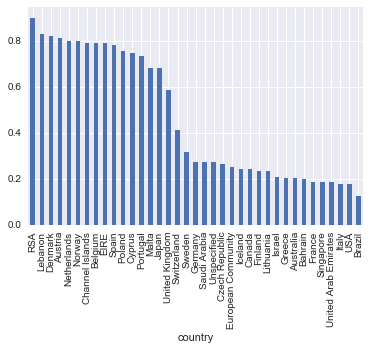

In [37]:
#also we could do an additional analysis with lightfm model results. for example, we could see AUC score by countries 
auc_score_by_id = pd.DataFrame(train_auc, index=df_cust['customer_id']).reset_index()
auc_score_by_id.columns = ['customer_id', 'auc_score']

data_w_auc = pd.merge(data, auc_score_by_id, on='customer_id', how='left')

data_w_auc = data_w_auc.groupby('country').agg({'auc_score': [np.mean, np.size]})
data_w_auc.columns = ['auc_score', 'sample_size']
data_w_auc['auc_score'].sort_values(ascending=False).plot(kind='bar');

## Classification Analysis: Decision Trees (CatBoost)

We use a tree-based algorithm to predict a probability of buying products by each customer. From one side knowing what would be bought in the future might help us to recommend relevant products to the customer (or visitor on the web-site), but from the other side we have a problem when we recommend to buy a product, which customer wanted to buy even without this reco. We have to keep in mind this idea. The real performance of this approach have to be checked on a real web-site with A/B testing.

OK, for the classification analysis purpose, we create a fake DF, where we randomly generate products, which customer didn't buy. We generate fake 2 rows for each real (1/3 ratio). It's better to increase the value of fake rows up-to 5, but for this task we will stay with 2, because of our PC power and additional memory consumption.

#### STEPS:
- generate a random dataset
- create DF with 0 and 1 classes
- split and save test DF on PC
- data preprocessing for CatBoostClassifier
- cross-validation (5-Folds)
- M x N matrix with answers

In [9]:
%%time
#add random choosen products to the initial dataset (as zero examples)

NUM_DUPL = 2 #duplicates number

df_inv_prod = data.groupby('invoice_no')['product_id'].apply(lambda x: list(x)).reset_index()

df_inv_prod['zero_ex'] = df_inv_prod['product_id'].apply(lambda x: random.choices(list(set(list(products)) - set(x)), 
                                                                                  k=len(x) * NUM_DUPL))

df_inv_prod['len'] = df_inv_prod['zero_ex'].apply(lambda x: len(x))

df_inv_prod = pd.concat([df_inv_prod['zero_ex'].apply(pd.Series).stack().reset_index(drop=True),
                         pd.Series.repeat(df_inv_prod['invoice_no'], reps=df_inv_prod['len']).reset_index(drop=True)], axis=1)

df_inv_prod.columns = ['product_id', 'invoice_no']

df_inv_prod = pd.merge(df_inv_prod, data.drop(['product_id', 'quantity', 'unit_price', 
                                               'ttl_price_ln', 'ones', 'id_ctry_weight'], 
                                              axis=1).groupby(['invoice_no', 'country', 'invoice_date']).mean().reset_index(),
                       on='invoice_no', how='left')

df_inv_prod.head()

Wall time: 13 s


In [10]:
%%time
#create DF for solving binary classification problem (decision tree approach)

df_class = pd.concat([data, df_inv_prod])[
    ['country', 'customer_id', 'invoice_no', 'ones', 'product_id']].fillna(0)

df_cust_inv_num = df_class.groupby(['customer_id', 'invoice_no'])['ones'].max().reset_index()
df_cust_inv_num['inv_num'] = df_class.groupby(
    ['customer_id', 'invoice_no'])['ones'].max().reset_index().groupby('customer_id')['ones'].transform(pd.Series.cumsum)

df_class = pd.merge(df_class, df_cust_inv_num[['customer_id', 'invoice_no', 'inv_num']],
                    on=['customer_id', 'invoice_no'], how='left')

df_class.drop('invoice_no', axis=1, inplace=True)

df_class.head()

Wall time: 2.13 s


In [ ]:
"""

%%time
#create test DF, where for each customer we add the unique products vector // split test DF on 3 parts

unique_customers = df_class.customer_id.unique()
unique_customers_dict = {}

unique_customers_dict['1'] = list(df_class.customer_id.unique())[: int(1/3 * len(unique_customers))]
unique_customers_dict['2'] = list(df_class.customer_id.unique())[int(1/3 * len(unique_customers)) : 
                                                                 int(2/3 * len(unique_customers))]
unique_customers_dict['3'] = list(df_class.customer_id.unique())[int(2/3 * len(unique_customers)) :]

for t in [1,2,3]:
    test = pd.DataFrame()
    
    for cust in tqdm_notebook(unique_customers_dict[str(t)]):
        df = pd.DataFrame(products)
        df.columns = ['product_id']
    
        df['customer_id'] = int(cust)
        df['country'] = df_unique_ctry[df_unique_ctry.customer_id == int(cust)]['country'].values[0]
        df['inv_num'] = df_class[df_class['customer_id'] == int(cust)]['inv_num'].max()+1
    
        test = pd.concat([test, df], axis=0)
        
    test.to_csv(path + '/test0' + str(t) + '.csv')

In [11]:
#highlight categorical features and encode them

cat_feat = ['country', 'customer_id', 'product_id']

lbl = LabelEncoder()

label_dict = {}

for lab in cat_feat:
    label = lbl.fit_transform(df_class[lab].unique())
    label_dict[lab] = dict(zip(lbl.classes_, range(len(lbl.classes_))))

#save indexes of categorical features for CatBoost
cat_feat_ind = []

for i in cat_feat:
    cat_feat_ind.append(list(df_class.columns).index(i))
    
#add extra features to DF (pool of these features could be expanded to achive a high accuracy metric)
df_class = pd.merge(df_class, df_cust, on='customer_id', how='left')
df_class = pd.merge(df_class, df_prod, on='product_id', how='left')
df_class = pd.merge(df_class, df_ctry, on='country', how='left')

#mapping labels from the dictionary for category variables
for cat in cat_feat:
    df_class[cat] = df_class[cat].map(label_dict[cat])

In [12]:
#create train DF and target vector Y

train = df_class.drop('ones', axis=1)
train_y = df_class['ones']
    
train_pool = Pool(train, label=train_y, cat_features=cat_feat_ind, has_header=True)

In [32]:
%%time

#train CatBoost model
model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.05,  
                           random_seed = 17,
                           custom_metric = ['AUC'],
                           logging_level='Silent')
    
model.fit(train_pool)

pred = model.predict(train_pool)
print("ROC-AUC score = {}".format(roc_auc_score(train_y, pred)))

ROC-AUC score = 0.7151607364457707
Wall time: 1min 7s


In [ ]:
"""

%%time

#cross-validation
K=5

kf = KFold(n_splits=K, random_state=17, shuffle=True)
kf.get_n_splits(range(len(df_class)))  

for i, (train_index, valid_index) in enumerate(kf.split(range(len(df_class)))):
    df1 = df_class.loc[train_index].copy()
    df2 = df_class.loc[valid_index].copy()

    df1.to_csv(path + "/train" + str(i) + ".csv",index=False)
    df2.to_csv(path + "/valid" + str(i) + ".csv", index=False)

In [ ]:
"""

%%time

#train and evaluate our model on each fold
pred_test = 0

for i in range(K):

    TRAIN_FILE = pd.read_csv(path + "/train" + str(i) + ".csv")
    VAL_FILE = pd.read_csv(path + "/valid" + str(i) + ".csv")

    train_pool = Pool(TRAIN_FILE.drop('ones', axis=1), label=TRAIN_FILE['ones'], cat_features=cat_feat_ind, has_header=True)
    val_pool = Pool(VAL_FILE.drop('ones', axis=1), label=VAL_FILE['ones'], cat_features=cat_feat_ind, has_header=True)

    
    
    model = CatBoostClassifier(iterations=10, 
                           learning_rate=0.05,  
                           random_seed = 17,
                           custom_metric = ['AUC'],
                           logging_level='Silent')
    
    model.fit(train_pool, eval_set = val_pool)
    
    test_prob_vector = np.arange(2)
    
    for i in [1, 2, 3]:
        test = pd.read_csv(path + '/test0' + str(i) + '.csv', index_col='Unnamed: 0')
    
        test = pd.merge(test, df_cust, on='customer_id', how='left')
        test = pd.merge(test, df_prod, on='product_id', how='left')
        test = pd.merge(test, df_ctry, on='country', how='left')
    
        for cat in cat_feat:
            test[cat] = test[cat].map(label_dict[cat])
    
        test = test[TRAIN_FILE.drop('ones', axis=1).columns]
    
        test_pool = Pool(test, cat_features=cat_feat_ind, has_header=True)
        del test
        
        test_prob_vector = np.vstack((test_prob_vector, model.predict_proba(test_pool)))
    
    pred_test = test_prob_vector + pred_test

pred_test = pred_test / K

In [34]:
%%time

#create vectores of products and custumers
test_index = np.arange(2) #product_id, customer_id
results_catboost = np.arange(1)


for i in [1, 2, 3]:
    test = pd.read_csv(path + /'test0' + str(i) + '.csv', index_col='Unnamed: 0')
    test_index = np.vstack((test_index, test[['product_id', 'customer_id']].values))

    test = pd.merge(test, df_cust, on='customer_id', how='left')
    test = pd.merge(test, df_prod, on='product_id', how='left')
    test = pd.merge(test, df_ctry, on='country', how='left')
    
    for cat in cat_feat:
        test[cat] = test[cat].map(label_dict[cat])
    
    test = test[train.columns]
    
    test_pool = Pool(test, cat_features=cat_feat_ind, has_header=True)
    del test
    
    results_catboost = np.vstack((results_catboost, model.predict_proba(test_pool)[:,1:]))
    

test_index = test_index[1:]  
results_catboost = results_catboost[1:]

Wall time: 4min 43s


In [ ]:
#create N x M matrix with answers

global_prob_mean = 1/3 #global probability; in our fake dataset we have 1/3 ratio for one purchased item

df_results_catboost = pd.DataFrame(test_index)
df_results_catboost.columns = ['product_id', 'customer_id']
df_results_catboost['prob'] = results_catboost - global_prob_mean

df_results_catboost = pd.pivot_table(df_results_catboost, index='customer_id', columns='product_id', 
                                     values='prob', aggfunc=np.sum)

In [59]:
df_results_catboost.to_csv(path + '/results_catboost.csv')

## Calculate Final Matrix

We rank each row (customer_id) in matrices to get results in one-dimensionality. Then we mix these matrices.

In [92]:
#finally we have 2 matrices, which we might blend with weights equal weights
df_results_lightfm = pd.read_csv(path + '/results_lightfm.csv', index_col='customer_id')
df_results_catboost = pd.read_csv(path + '/results_catboost.csv', index_col='customer_id')

In [100]:
#submission: rank each customer and mix results of 2 models
((df_results_lightfm.rank(axis=1) + 
  df_results_catboost.rank(axis=1))).to_csv(path + '/submission.csv')

##### The submission file is quite large and I unable to upload this file on github, so I uploaded the file on cloud: 

https://drive.google.com/open?id=1iJVrHdZUOLtfsYJ416N6pbhiiHptSeqN

## Conclusion

I think a proper validation for this approach would be A/B testing, which evaluates the impact of a new model by running it in a real production environment and testing its performance on a subset of the users of the platform. Admittedly, it's desirable to investigate deeper to achieve more insights into customers' behavior. For instance, we could also test the following ideas:
- **Market Basket Analysis** (Apriori Analysis & Association Rules) as part of Exploratory Data Analysis (EDA) *(LightFM uses these techniques in a context of matrix factorization, but with Market Basket Analysis we gain valuable insights for business such as understanding which products occur together in transactions. It doesn't give us good predictions, but it shows similarities of products and products' categories)*
- to work with **Product possible features** (best selling/most-frequent products, price segments, comparison of products sets (neighbors / up-selling (selling additional items that complement the item purchased), and cross-selling (selling items in other independent category the customer might be interested in)), **Customer possible features** (customers segmentation: RFM (Recency, Frequency, Monetary), PCA; Sociodemographic characteristics), **Seasonality factors**